# Wage Gap Prediction

# Plugin - Running ML model or use static data

In [112]:
run_model = False
static_model_filename = 'finalized_model_lasso.sav'

## Data preparation and cleaning

## 1 Import Python Libraries

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sklearn
import matplotlib.pyplot as plt
import sklearn.preprocessing as sp
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from  sklearn import feature_selection 
from sklearn import linear_model
from sklearn import metrics
from pandas.stats.api import ols
import pickle

## 2 Load CSVs

In [114]:
# in
gender_data_raw = pd.read_csv('working_data\GenderStat_Data_new.csv',header=None,skiprows=0)
print ('number of features in the original gender stats data : {0}'.format(len(set(gender_data_raw[2]))))

payment_gap_oecd_raw = pd.read_csv('working_data\Payment_gap_oecd.csv', header=None,skiprows = 1)
print('payment gap OECD example:')
payment_gap_oecd_raw.head(10)

number of features in the original gender stats data : 689
payment gap OECD example:


,0,1,2,3,4,5,6,7
0,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1975,21.582733,Australia
1,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1976,20.754717,Australia
2,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1977,18.390804,Australia
3,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1978,19.791666,Australia
4,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1979,20.000000,Australia
5,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1980,18.750000,Australia
6,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1981,18.253969,Australia
7,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1982,20.819113,Australia
8,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1983,19.155844,Australia
9,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1984,18.674698,Australia


## 3 Travers years and indicator in GenderStats

In [115]:
# variables from outside the cell gender_data_raw

#remove the columns - 'Country Code', 'Indicator Code'
gender_data_raw.drop(gender_data_raw.columns[[1,3]], axis=1, inplace=True)
#rename 'Country Name' column to 'country-full-name', in order to be adjusted to payment_gap_oecd_raw
gender_data_raw.loc[0,0] = 'country-full-name'

#tranvers columns by pivot table
gender_data_raw.columns = gender_data_raw.loc[0]
gender_data_raw = pd.pivot_table(gender_data_raw,index ='country-full-name', columns='Indicator Name')

gender_data_raw = gender_data_raw.stack(level=0)
gender_data_raw.reset_index(inplace=True)
gender_data_raw.rename(columns={0:'Year'},inplace=True)
gender_data_raw.rename(columns={"Indicator Name":'Id'},inplace=True)
gender_data_raw.to_csv("TempCsv.csv")

#reading for creating new normelized data frame
gender_stats_normalized = pd.read_csv("TempCsv.csv")
gender_stats_normalized.drop(gender_stats_normalized.columns[[0]], axis=1, inplace=True)
gender_stats_normalized.head()

,country-full-name,Year,"Access to anti-retroviral drugs, female (%)","Access to anti-retroviral drugs, male (%)","Account at a financial institution, female (% age 15+) [ts]","Account at a financial institution, male (% age 15+) [ts]","Adolescent fertility rate (births per 1,000 women ages 15-19)","Age at first marriage, female","Age at first marriage, male",Age dependency ratio (% of working-age population),...,Women who own land both alone and jointly (% of women age 15-49): Q3,Women who own land both alone and jointly (% of women age 15-49): Q4,Women who own land both alone and jointly (% of women age 15-49): Q5 (highest),Women who own land jointly (% of women age 15-49),Women who own land jointly (% of women age 15-49): Q1 (lowest),Women who own land jointly (% of women age 15-49): Q2,Women who own land jointly (% of women age 15-49): Q3,Women who own land jointly (% of women age 15-49): Q4,Women who own land jointly (% of women age 15-49): Q5 (highest),Women who were first married by age 18 (% of women ages 20-24)
0,Australia,1960.0,NaN,NaN,NaN,NaN,44.8286,NaN,NaN,63.356535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Australia,1961.0,NaN,NaN,NaN,NaN,45.0668,NaN,NaN,63.596913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Australia,1962.0,NaN,NaN,NaN,NaN,45.3050,NaN,NaN,63.372475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Australia,1963.0,NaN,NaN,NaN,NaN,45.9764,NaN,NaN,62.857899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Australia,1964.0,NaN,NaN,NaN,NaN,46.6478,NaN,NaN,62.304998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4 Adding Header to Data Files and removing duplicates from OECD csv

In [116]:
payment_gap_oecd_raw.columns = ['location', 'indicator', 'subject', 'measure', 'frequency', 'Year', 'WageGaP', 'country-full-name']

#removing duplicate values for the same year in the OECD csv
payment_gap_oecd_raw = payment_gap_oecd_raw[payment_gap_oecd_raw['subject'] == 'TOT']

## 5 Intersect Countries and merge two csv's

In [117]:
#checking both csv's - country-full-name
#csv's - gender_stats_normalized, payment_gap_oecd_raw
new_data_raw = pd.merge(gender_stats_normalized, payment_gap_oecd_raw, how='inner', on=['country-full-name', 'Year'])
new_data_raw.head(10)

,country-full-name,Year,"Access to anti-retroviral drugs, female (%)","Access to anti-retroviral drugs, male (%)","Account at a financial institution, female (% age 15+) [ts]","Account at a financial institution, male (% age 15+) [ts]","Adolescent fertility rate (births per 1,000 women ages 15-19)","Age at first marriage, female","Age at first marriage, male",Age dependency ratio (% of working-age population),...,Women who own land jointly (% of women age 15-49): Q3,Women who own land jointly (% of women age 15-49): Q4,Women who own land jointly (% of women age 15-49): Q5 (highest),Women who were first married by age 18 (% of women ages 20-24),location,indicator,subject,measure,frequency,WageGaP
0,Australia,1975.0,NaN,NaN,NaN,NaN,38.5016,NaN,NaN,56.816075,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,21.582733
1,Australia,1976.0,NaN,NaN,NaN,NaN,35.1688,22.0,24.4,56.478399,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,20.754717
2,Australia,1977.0,NaN,NaN,NaN,NaN,31.8360,NaN,NaN,55.782389,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,18.390804
3,Australia,1978.0,NaN,NaN,NaN,NaN,30.6870,NaN,NaN,54.923225,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,19.791666
4,Australia,1979.0,NaN,NaN,NaN,NaN,29.5380,NaN,NaN,54.143916,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,20.000000
5,Australia,1980.0,NaN,NaN,NaN,NaN,28.3890,NaN,NaN,53.550174,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,18.750000
6,Australia,1981.0,NaN,NaN,NaN,NaN,27.2400,23.5,25.7,52.703024,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,18.253969
7,Australia,1982.0,NaN,NaN,NaN,NaN,26.0910,NaN,NaN,52.204834,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,20.819113
8,Australia,1983.0,NaN,NaN,NaN,NaN,25.0928,NaN,NaN,51.904419,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,19.155844
9,Australia,1984.0,NaN,NaN,NaN,NaN,24.0946,NaN,NaN,51.574265,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,18.674698


## 6 Drop unnecessary columns And remove rows with too many NANs

In [118]:
new_data_raw.drop('subject', axis=1, inplace=True)
new_data_raw.drop('indicator', axis=1, inplace=True)
new_data_raw.drop('location', axis=1, inplace=True)
new_data_raw.drop('frequency', axis=1, inplace=True)
new_data_raw.drop('measure', axis=1, inplace=True)

#thresh is the minimum number of non NAN values
new_data_raw = new_data_raw.dropna(1,thresh = new_data_raw.shape[0] * 90 / 100)

## 7  Convert country-full-name columns to binary columns

In [119]:
cols = new_data_raw.columns.tolist()
cols_to_transform = [cols[0]]
binary_countries = pd.get_dummies(data = new_data_raw,columns=cols_to_transform)
countries = set(new_data_raw['country-full-name'])
countries_count = len(countries)

#country column will br converted to float type with value 1.0 if it is relevent to specific row else 0.0s
cols = binary_countries.columns.tolist()
cols = cols[-countries_count:] + cols[:-countries_count]
binary_countries = binary_countries[cols]
binary_countries.head(3)

,country-full-name_Australia,country-full-name_Austria,country-full-name_Belgium,country-full-name_Canada,country-full-name_Chile,country-full-name_Czech Republic,country-full-name_Denmark,country-full-name_Estonia,country-full-name_Finland,country-full-name_France,...,"Self-employed, male (% of males employed)","Unemployment, female (% of female labor force) (national estimate)","Unemployment, male (% of male labor force) (national estimate)","Unemployment, total (% of total labor force) (national estimate)","Unemployment, youth female (% of female labor force ages 15-24) (national estimate)","Unemployment, youth male (% of male labor force ages 15-24) (national estimate)","Unemployment, youth total (% of total labor force ages 15-24) (national estimate)","Wage and salaried workers, female (% of females employed)","Wage and salary workers, male (% of males employed)",WageGaP
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.582733
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.754717
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.390804


## 8 Specifying Data Types

In [120]:
#convert all fearutes to float and countries to binaries, binary will be int
new_data_raw = binary_countries
cols = binary_countries.columns.tolist()
binary_variables = cols[0:countries_count]
numeric_variables = cols[countries_count:]

for variable in binary_variables:
    new_data_raw[variable] = new_data_raw[variable].astype(np.int)
    
new_data_raw.head()

,country-full-name_Australia,country-full-name_Austria,country-full-name_Belgium,country-full-name_Canada,country-full-name_Chile,country-full-name_Czech Republic,country-full-name_Denmark,country-full-name_Estonia,country-full-name_Finland,country-full-name_France,...,"Self-employed, male (% of males employed)","Unemployment, female (% of female labor force) (national estimate)","Unemployment, male (% of male labor force) (national estimate)","Unemployment, total (% of total labor force) (national estimate)","Unemployment, youth female (% of female labor force ages 15-24) (national estimate)","Unemployment, youth male (% of male labor force ages 15-24) (national estimate)","Unemployment, youth total (% of total labor force ages 15-24) (national estimate)","Wage and salaried workers, female (% of females employed)","Wage and salary workers, male (% of males employed)",WageGaP
0,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.582733
1,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.754717
2,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.390804
3,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.791666
4,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.000000


## 9 Impute Missing Values

In [121]:
data_no_na = new_data_raw
cols = data_no_na.columns.tolist()
imputed_variables = cols[countries_count+1:]
for variable in imputed_variables:
    data_no_na[variable].fillna(method='ffill', inplace=True)
    data_no_na[variable].fillna(method='bfill', inplace=True)

data_no_na.head()

,country-full-name_Australia,country-full-name_Austria,country-full-name_Belgium,country-full-name_Canada,country-full-name_Chile,country-full-name_Czech Republic,country-full-name_Denmark,country-full-name_Estonia,country-full-name_Finland,country-full-name_France,...,"Self-employed, male (% of males employed)","Unemployment, female (% of female labor force) (national estimate)","Unemployment, male (% of male labor force) (national estimate)","Unemployment, total (% of total labor force) (national estimate)","Unemployment, youth female (% of female labor force ages 15-24) (national estimate)","Unemployment, youth male (% of male labor force ages 15-24) (national estimate)","Unemployment, youth total (% of total labor force ages 15-24) (national estimate)","Wage and salaried workers, female (% of females employed)","Wage and salary workers, male (% of males employed)",WageGaP
0,1,0,0,0,0,0,0,0,0,0,...,17.799999,7.9,5.1,6.1,13.9,11.4,12.5,87.099998,82.199997,21.582733
1,1,0,0,0,0,0,0,0,0,0,...,17.799999,7.9,5.1,6.1,13.9,11.4,12.5,87.099998,82.199997,20.754717
2,1,0,0,0,0,0,0,0,0,0,...,17.799999,7.9,5.1,6.1,13.9,11.4,12.5,87.099998,82.199997,18.390804
3,1,0,0,0,0,0,0,0,0,0,...,17.799999,7.9,5.1,6.1,13.9,11.4,12.5,87.099998,82.199997,19.791666
4,1,0,0,0,0,0,0,0,0,0,...,17.799999,7.9,5.1,6.1,13.9,11.4,12.5,87.099998,82.199997,20.000000


## 10 Vizualization

## 10.2 presenting histogram of wageGap

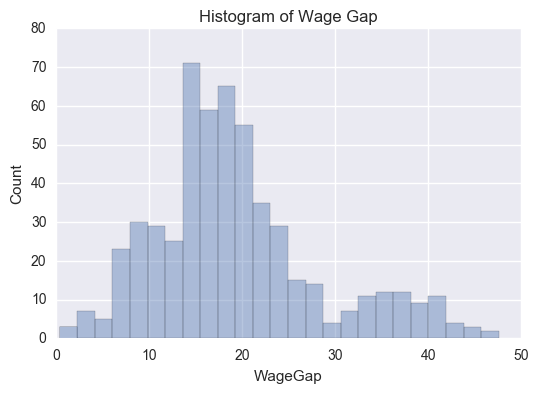

In [122]:
%matplotlib inline
sns.distplot(data_no_na.WageGaP, bins = 25, kde = False)
plt.title('Histogram of Wage Gap')
plt.xlabel('WageGap')
plt.ylabel('Count')

## 11 split to X and Y

In [123]:
x = data_no_na[list(data_no_na)[:-1]]

#split y to train and test by year
traintest_threshold = 2010
y_train = data_no_na[data_no_na['Year'] < traintest_threshold ]
y_train = y_train['WageGaP']

y_test = data_no_na[data_no_na['Year'] >= traintest_threshold ]
y_test = y_test['WageGaP']

## 12 Normelize all values in X

In [124]:
#normelized values in x will be in range(0,1)
l = list(data_no_na)
x_normelize = pd.DataFrame(sp.MinMaxScaler().fit_transform(data_no_na),columns = l)
#remove the prediction column from x
x_normelize.drop('WageGaP', axis=1, inplace=True)

## 13 split X to train and test data

In [125]:
#train will contain years 1975-2010
min_year = min(data_no_na['Year']); max_year=max(data_no_na['Year']);
normalized_threshold = ((traintest_threshold - min_year)/(max_year - min_year))
x_train = x_normelize[x_normelize['Year'] < normalized_threshold]
x_test = x_normelize[x_normelize['Year'] >= normalized_threshold]

## 14 Data Modeling

continue working with x_train, x_test, y_train, y_test

## 14.1 ML - linear regression using sklearn

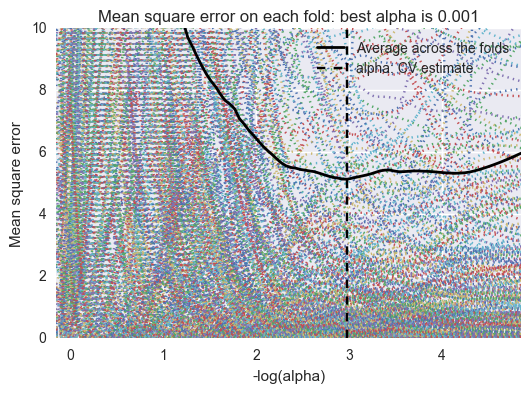

In [126]:
n_fold_cv = x_train.shape[0]
if run_model:
    model = linear_model.LassoCV(max_iter=1000,eps=1e-5,n_alphas=100, cv=n_fold_cv).fit(x_train,y_train)
else:#load model from pickle object
    model = pickle.load(open(static_model_filename, 'rb'))

   
m_log_alphas = -np.log10(model.alphas_) 

 # Display results
plt.figure()
ymin, ymax = 0, 10
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: best alpha is %.3f' %model.alpha_)
plt.axis('tight')
plt.ylim(ymin, ymax)
plt.show()

In [127]:
#coefficients remaining
model.coef_

array([ -4.40573804,   3.85421195,  -5.24435758,   6.81339053,
        -6.20026143,   1.52976083,  -6.64287614,   5.41025664,
         5.04855567,  -0.14495592,   2.03958025,   0.        ,
       -16.18967494,  -0.        ,  21.70125494, -15.47539276,
        -0.91521351,   0.        ,  -3.08555263,  -5.74971769,
         0.        ,  -6.51298486,   1.88027626,  -1.02189418,
         0.        ,  -3.06747011,   2.89860049,   5.73024495,
         0.        ,   9.06416854,  17.17886324,  -0.        ,
        -9.26375359,  -5.56328367,  -7.02604005,  -0.        ,
        -4.4837332 ,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ,
        -1.88684689,  -0.        ,  -1.71376732,   0.80753065,
       -12.80890922, -14.14594298,  -7.2290952 ,  12.04293377,
         0.        ,   0.        ,   9.40166119,  -9.0771082 ,
         2.19674649,   0.25652159,   0.5487346 ,  -8.10508871,
        -0.        ,  -0.94611826,  -0.        ,   6.45

## 14.2 getting the model error

In [128]:
#get the error
y_hat_test_sklearn = model.predict(x_test)
err = metrics.mean_squared_error(y_test,y_hat_test_sklearn)
print ('test mse is : %.2f' %err)

test mse is : 14.32


## 14.3 printing the remaining features

In [129]:
#remaining features
sfm = feature_selection.SelectFromModel(model, prefit=True)
remaining_features = [list(x_train)[i] for i in sfm.get_support(True)]
print ('The renaming features after lasso selection:')
countries = [x for x in remaining_features if 'country' in x]
print (len(remaining_features))
print ('countries count {0}'.format(len(countries)))
remaining_countries_count = len(countries)

The renaming features after lasso selection:
55
countries count 25


## 15 Visualization 2

## 15.1 wage gap graph vs year for each country

Total Countries 31
Countries in feature list 25


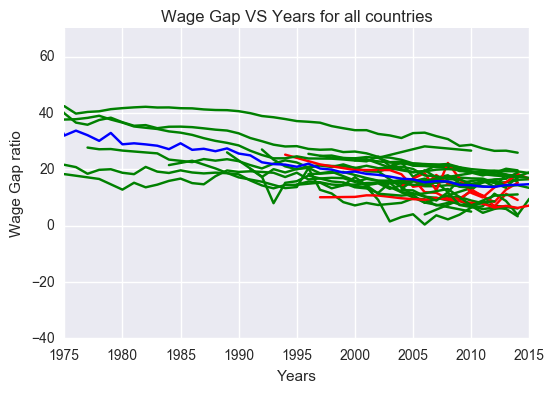

In [130]:
%matplotlib inline
#green - countries in features
#red- countries that are not in features
#blue- avverage on all countries
#creating x again in case x was changed during the last operatiotn
x = data_no_na[list(data_no_na)[:-1]]

#create x vector
plot_data = data_no_na
years = set(plot_data['Year'])
years=list(years)
country_colums_list = list(x)[0:countries_count]
y_graphs_dict = {}
#split to x axis (years) and y axis(wage gap)
for country in country_colums_list:
     y_vector = plot_data[plot_data[country] == 1]
     y_vector=pd.DataFrame(y_vector, columns = ['Year','WageGaP'])
     y_graphs_dict[country] = y_vector

#add average
aggregated = plot_data.groupby('Year').mean()['WageGaP']
aggregated_wg = aggregated.to_frame(name='WageGaP_Avg')
np_array_gap_average = aggregated_wg['WageGaP_Avg'].values
y_graphs_dict['WageGapAvg'] = np_array_gap_average.tolist()

plt.show()
plot_tuple = ()
feature_countries = [x for x in remaining_features if x.startswith('country')]
print ('Total Countries {0}'.format(len(country_colums_list)))
print ('Countries in feature list {0}'.format(len(feature_countries)))

#plotting the graphs with relevent colors
for country in country_colums_list:
    color = 'r'
    if country in remaining_features:
        color = 'g'
    plot_tuple =  plot_tuple+(y_graphs_dict[country].Year,y_graphs_dict[country].WageGaP,color)

#ploting average in blue color
plot_tuple =  plot_tuple+(years,y_graphs_dict['WageGapAvg'],'b')

for i in range(0,len(plot_tuple),3):
    plt.plot(plot_tuple[i],plot_tuple[i+1],plot_tuple[i+2])

plt.ylabel('Wage Gap ratio')
plt.xlabel('Years')
plt.title('Wage Gap VS Years for all countries')
plt.xlim(1975,2015)
plt.ylim(-40,70)
plt.show()

## 15.2 test_Prediction vs test_Data 

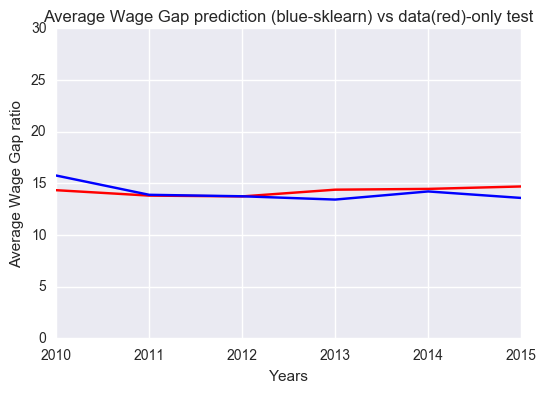

In [131]:
%matplotlib inline

test = data_no_na[data_no_na['Year'] >= traintest_threshold]

plot_data = test[['Year','WageGaP']]
plot_data = plot_data.groupby('Year').mean()

cols = test.columns.tolist()
test_2 = test.reset_index(drop=True)
test_2.columns = cols

df_y_hat_sklearn = pd.DataFrame(data=y_hat_test_sklearn,columns=['WageGaPPredict'])

df_prediction_sklearn_only_test = pd.concat([test_2,df_y_hat_sklearn], axis=1, join='inner')
plot_Prediction_sklearn_only_test = df_prediction_sklearn_only_test[['Year','WageGaPPredict']]
plot_Prediction_sklearn_only_test = plot_Prediction_sklearn_only_test.groupby('Year').mean()

lines = plt.plot(plot_data.index,plot_data.WageGaP,color='r')
lines = plt.plot(plot_Prediction_sklearn_only_test.index,plot_Prediction_sklearn_only_test.WageGaPPredict,color='b')

plt.ylabel('Average Wage Gap ratio')
plt.xlabel('Years')
plt.title('Average Wage Gap prediction (blue-sklearn) vs data(red)-only test')
plt.ylim(0,30)
plt.xlim(traintest_threshold,2015)
plt.ticklabel_format(useOffset=False)
plt.show()

## 15.3 Test prediction vs data Average error precentage

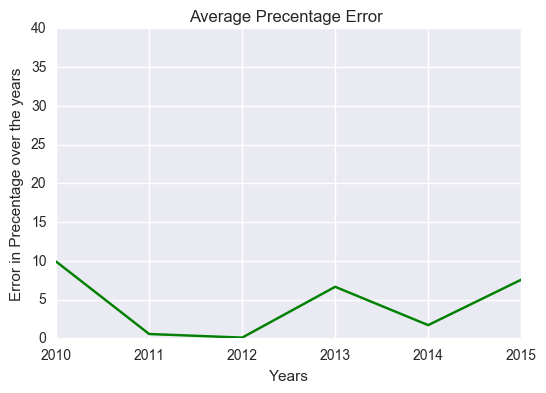

average error in precentage: 4.41
max error in precentage: 9.90


In [132]:
test = data_no_na[data_no_na['Year'] >= traintest_threshold]

cols = test.columns.tolist()
test_2 = test.reset_index(drop=True)
test_2.columns = cols

df_y_hat_sklearn_only_test = pd.DataFrame(data=y_hat_test_sklearn,columns=['WageGaPPredict'])

df_prediction_and_data_sklearn = pd.concat([test_2,df_y_hat_sklearn_only_test], axis=1, join='inner')

df_data_sklearn = df_prediction_and_data_sklearn[['Year','WageGaPPredict']]
df_prediction_sklearn = df_prediction_and_data_sklearn[['Year','WageGaP']]

df_data_sklearn_mean = df_data_sklearn.groupby('Year').mean()
df_prediction_sklearn_mean = df_prediction_sklearn.groupby('Year').mean()

df_prediction_and_data_sklearn_mean = pd.concat([df_data_sklearn_mean,df_prediction_sklearn_mean], axis=1, join='inner')

precentage_error_sklearn = ((abs(df_prediction_and_data_sklearn_mean['WageGaPPredict']-df_prediction_and_data_sklearn_mean['WageGaP'])/df_prediction_and_data_sklearn_mean['WageGaP'])*100)
df_precentage_error_sklearn = pd.DataFrame(data=precentage_error_sklearn,columns=['PrecentageErr'])

plot_precentageErr_sklearn = pd.concat([df_prediction_and_data_sklearn_mean,df_precentage_error_sklearn], axis=1, join='inner') 


lines = plt.plot(plot_precentageErr_sklearn.index,plot_precentageErr_sklearn.PrecentageErr,color='g')

plt.ylabel('Error in Precentage over the years')
plt.xlabel('Years')
plt.title('Average Precentage Error ')
plt.ylim(0,40)
plt.ticklabel_format(useOffset=False)
plt.show()

mean_err = np.mean(plot_precentageErr_sklearn.PrecentageErr)
max_err = np.max(plot_precentageErr_sklearn.PrecentageErr)

print('average error in precentage: %.2f' %mean_err)
print('max error in precentage: %.2f' %max_err)

## 16 Run Model on train and test

In [133]:
y_hat_sklearn = model.predict(x_normelize)

## 16.1 Visualize Prediction Vs Data (Train and Test)

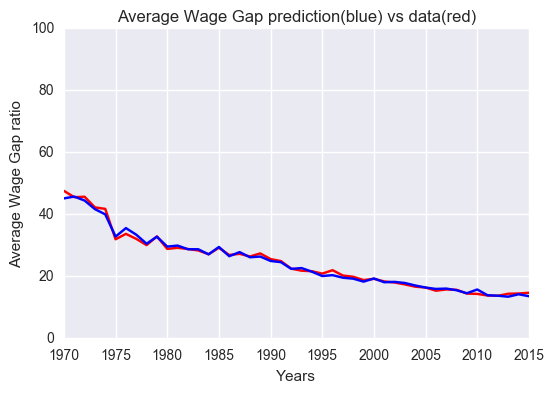

In [134]:
%matplotlib inline

plot_data = data_no_na[['Year','WageGaP']]
plot_data = plot_data.groupby('Year').mean()

# cols = x_normelize.columns.tolist()
# x_normelize_2 = x_normelize.reset_index(drop=True)
# x_normelize_2.columns = cols

df_y_hat_sklearn = pd.DataFrame(data=y_hat_sklearn,columns=['WageGaPPredict'])

df_prediction_and_data_sklearn = pd.concat([data_no_na,df_y_hat_sklearn], axis=1, join='inner')
plot_Prediction_sklearn = df_prediction_and_data_sklearn[['Year','WageGaPPredict']]
plot_Prediction_sklearn = plot_Prediction_sklearn.groupby('Year').mean()

lines = plt.plot(plot_data.index,plot_data.WageGaP,color='r')
lines = plt.plot(plot_Prediction_sklearn.index,plot_Prediction_sklearn.WageGaPPredict,color='b')

plt.ylabel('Average Wage Gap ratio')
plt.xlabel('Years')
plt.title('Average Wage Gap prediction(blue) vs data(red)')
plt.ylim(0,100)
plt.show()

## 16.2 Visualize Average Error Precentage

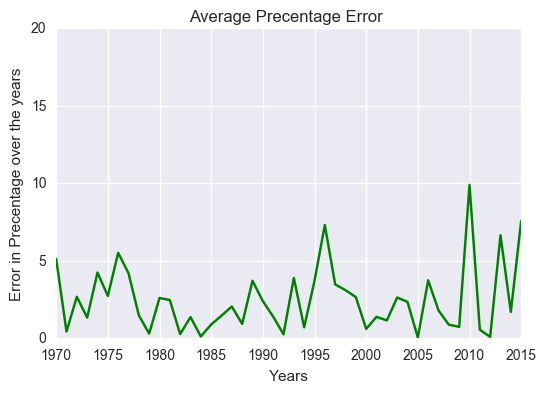

average error in precentage: 2.49
max error in precentage: 9.90


In [135]:
df_y_hat_sklearn_only_test = pd.DataFrame(data=y_hat_test_sklearn,columns=['WageGaPPredict'])

df_y_hat_sklearn = pd.DataFrame(data=y_hat_sklearn,columns=['WageGaPPredict'])

df_prediction_and_data_sklearn = pd.concat([data_no_na,df_y_hat_sklearn], axis=1, join='inner')

df_data_sklearn = df_prediction_and_data_sklearn[['Year','WageGaPPredict']]
df_prediction_sklearn = df_prediction_and_data_sklearn[['Year','WageGaP']]

df_data_sklearn_mean = df_data_sklearn.groupby('Year').mean()
df_prediction_sklearn_mean = df_prediction_sklearn.groupby('Year').mean()

df_prediction_and_data_sklearn_mean = pd.concat([df_data_sklearn_mean,df_prediction_sklearn_mean], axis=1, join='inner')

precentage_error_sklearn = ((abs(df_prediction_and_data_sklearn_mean['WageGaPPredict']-df_prediction_and_data_sklearn_mean['WageGaP'])/df_prediction_and_data_sklearn_mean['WageGaP'])*100)
df_precentage_error_sklearn = pd.DataFrame(data=precentage_error_sklearn,columns=['PrecentageErr'])

plot_precentageErr_sklearn = pd.concat([df_prediction_and_data_sklearn_mean,df_precentage_error_sklearn], axis=1, join='inner') 


lines = plt.plot(plot_precentageErr_sklearn.index,plot_precentageErr_sklearn.PrecentageErr,color='g')

plt.ylabel('Error in Precentage over the years')
plt.xlabel('Years')
plt.title('Average Precentage Error ')
plt.ylim(0,20)
plt.ticklabel_format(useOffset=False)
plt.show()

mean_err = np.mean(plot_precentageErr_sklearn.PrecentageErr)
max_err = np.max(plot_precentageErr_sklearn.PrecentageErr)

print('average error in precentage: %.2f' %mean_err)
print('max error in precentage: %.2f' %max_err)

# 17 Data Modeling (II)

## 17.1 ML - linear regression using statsmodels

In [136]:
x_train_stats = x_train[remaining_features]

stats_model = sm.OLS(y_train,x_train_stats)
stats_model_results = stats_model.fit()
print(stats_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                WageGaP   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1123.
Date:                Thu, 16 Feb 2017   Prob (F-statistic):               0.00
Time:                        18:52:04   Log-Likelihood:                -816.05
No. Observations:                 414   AIC:                             1742.
Df Residuals:                     359   BIC:                             1964.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                                                                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------

## 17.2 calculation statsmodel mse

In [137]:
x_test_stats = x_test[remaining_features]
y_hat_test_stats = stats_model_results.predict(x_test_stats)
err = metrics.mean_squared_error(y_test,y_hat_test_stats)
print ('statsmodel test mse is : %.2f' %err)

statsmodel test mse is : 16.12


# 18 Visualization statsmodel results

## 18.1 test_Prediction vs test_Data (statsmodel)

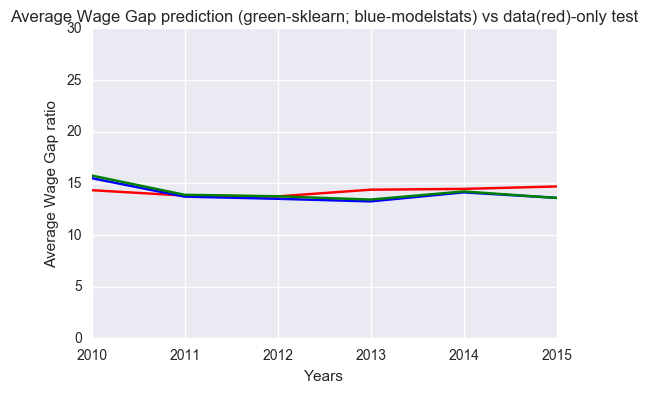

In [138]:
%matplotlib inline

test = data_no_na[data_no_na['Year'] >= traintest_threshold]

plot_data = test[['Year','WageGaP']]
plot_data = plot_data.groupby('Year').mean()

cols = test.columns.tolist()
test_2 = test.reset_index(drop=True)
test_2.columns = cols

df_y_hat_sklearn = pd.DataFrame(data=y_hat_test_sklearn,columns=['WageGaPPredict'])

df_prediction_sklearn_only_test = pd.concat([test_2,df_y_hat_sklearn], axis=1, join='inner')
plot_Prediction_sklearn_only_test = df_prediction_sklearn_only_test[['Year','WageGaPPredict']]
plot_Prediction_sklearn_only_test = plot_Prediction_sklearn_only_test.groupby('Year').mean()

df_y_hat_stats = pd.DataFrame(data=y_hat_test_stats,columns=['WageGaPPredict'])

df_prediction_stats_only_test = pd.concat([test_2,df_y_hat_stats], axis=1, join='inner')
plot_Prediction_stats_only_test = df_prediction_stats_only_test[['Year','WageGaPPredict']]
plot_Prediction_stats_only_test = plot_Prediction_stats_only_test.groupby('Year').mean()

lines = plt.plot(plot_data.index,plot_data.WageGaP,color='r')
lines = plt.plot(plot_Prediction_stats_only_test.index,plot_Prediction_stats_only_test.WageGaPPredict,color='b')
lines = plt.plot(plot_Prediction_sklearn_only_test.index,plot_Prediction_sklearn_only_test.WageGaPPredict,color='g')

plt.ylabel('Average Wage Gap ratio')
plt.xlabel('Years')
plt.title('Average Wage Gap prediction (green-sklearn; blue-modelstats) vs data(red)-only test')
plt.ylim(0,30)
plt.xlim(traintest_threshold,2015)
plt.ticklabel_format(useOffset=False)
plt.show()

# 19 Run statsmodels Model on train and test

In [139]:
y_hat_stats = stats_model_results.predict(x_normelize[remaining_features])

## 19.1 Visualize Prediction Vs Data Train and Test (statsmodels)

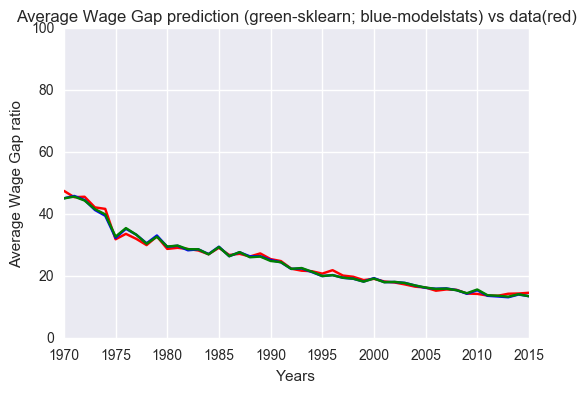

In [140]:
%matplotlib inline

plot_data = data_no_na[['Year','WageGaP']]
plot_data = plot_data.groupby('Year').mean()

df_y_hat_stats = pd.DataFrame(data=y_hat_stats,columns=['WageGaPPredict'])

df_prediction_stats = pd.concat([data_no_na,df_y_hat_stats], axis=1, join='inner')
plot_Prediction_stats = df_prediction_stats[['Year','WageGaPPredict']]
plot_Prediction_stats = plot_Prediction_stats.groupby('Year').mean()

df_y_hat_sklearn = pd.DataFrame(data=y_hat_sklearn,columns=['WageGaPPredict'])

df_prediction_sklearn = pd.concat([data_no_na,df_y_hat_sklearn], axis=1, join='inner')
plot_Prediction_sklearn = df_prediction_sklearn[['Year','WageGaPPredict']]
plot_Prediction_sklearn = plot_Prediction_sklearn.groupby('Year').mean()

lines = plt.plot(plot_data.index,plot_data.WageGaP,color='r')
lines = plt.plot(plot_Prediction_stats.index,plot_Prediction_stats.WageGaPPredict,color='b')
lines = plt.plot(plot_Prediction_sklearn.index,plot_Prediction_sklearn.WageGaPPredict,color='g')

plt.ylabel('Average Wage Gap ratio')
plt.xlabel('Years')
plt.title('Average Wage Gap prediction (green-sklearn; blue-modelstats) vs data(red)')
plt.ylim(0,100)
plt.show()

## 19.2 Average Error Precentage (statsmodels)

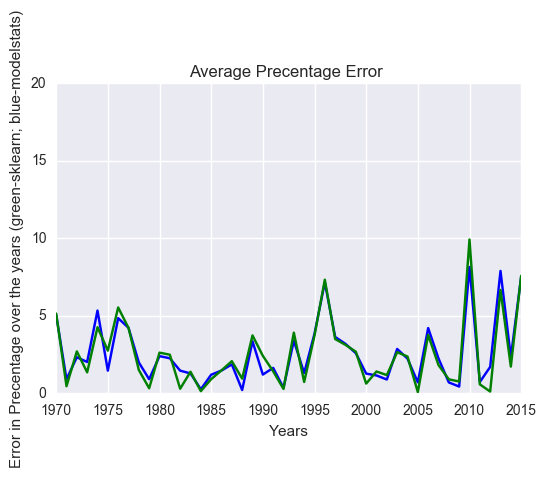

average error using sklearn in precentage: 2.49
max error using sklearn in precentage: 9.90

average error using modelstats in precentage: 2.55
max error using modelstats in precentage: 8.13


In [141]:
# preparing data for sklearn
df_y_hat_sklearn_only_test = pd.DataFrame(data=y_hat_test_sklearn,columns=['WageGaPPredict'])

df_y_hat_sklearn = pd.DataFrame(data=y_hat_sklearn,columns=['WageGaPPredict'])

df_prediction_and_data_sklearn = pd.concat([data_no_na,df_y_hat_sklearn], axis=1, join='inner')

df_data_sklearn = df_prediction_and_data_sklearn[['Year','WageGaPPredict']]
df_prediction_sklearn = df_prediction_and_data_sklearn[['Year','WageGaP']]

df_data_sklearn_mean = df_data_sklearn.groupby('Year').mean()
df_prediction_sklearn_mean = df_prediction_sklearn.groupby('Year').mean()

df_prediction_and_data_sklearn_mean = pd.concat([df_data_sklearn_mean,df_prediction_sklearn_mean], axis=1, join='inner')

precentage_error_sklearn = ((abs(df_prediction_and_data_sklearn_mean['WageGaPPredict']-df_prediction_and_data_sklearn_mean['WageGaP'])/df_prediction_and_data_sklearn_mean['WageGaP'])*100)
df_precentage_error_sklearn = pd.DataFrame(data=precentage_error_sklearn,columns=['PrecentageErr'])

plot_precentageErr_sklearn = pd.concat([df_prediction_and_data_sklearn_mean,df_precentage_error_sklearn], axis=1, join='inner') 

# preparing data for stats
df_y_hat_stats = pd.DataFrame(data=df_y_hat_stats,columns=['WageGaPPredict'])

df_prediction_and_data_stats = pd.concat([data_no_na,df_y_hat_stats], axis=1, join='inner')

df_data_stats = df_prediction_and_data_stats[['Year','WageGaP']]
df_prediction_stats = df_prediction_and_data_stats[['Year','WageGaPPredict']]

df_data_stats_mean = df_data_stats.groupby('Year').mean()
df_prediction_stats_mean = df_prediction_stats.groupby('Year').mean()

df_prediction_and_data_stats_mean = pd.concat([df_data_stats_mean,df_prediction_stats_mean], axis=1, join='inner')

precentage_error_stats = ((abs(df_prediction_and_data_stats_mean['WageGaPPredict']-df_prediction_and_data_stats_mean['WageGaP'])/df_prediction_and_data_stats_mean['WageGaP'])*100)
df_precentage_error_stats = pd.DataFrame(data=precentage_error_stats,columns=['PrecentageErr'])

plot_precentageErr_stats = pd.concat([df_prediction_and_data_stats_mean,df_precentage_error_stats], axis=1, join='inner') 

lines = plt.plot(plot_precentageErr_stats.index,plot_precentageErr_stats.PrecentageErr,color='b')
lines = plt.plot(plot_precentageErr_sklearn.index,plot_precentageErr_sklearn.PrecentageErr,color='g')

plt.ylabel('Error in Precentage over the years (green-sklearn; blue-modelstats)')
plt.xlabel('Years')
plt.title('Average Precentage Error ')
plt.ylim(0,20)
plt.ticklabel_format(useOffset=False)
plt.show()

err_mean_sklearn = np.mean(plot_precentageErr_sklearn.PrecentageErr)
err_max_sklearn = np.max(plot_precentageErr_sklearn.PrecentageErr)

err_mean_stats = np.mean(plot_precentageErr_stats.PrecentageErr)
err_max_stats = np.max(plot_precentageErr_stats.PrecentageErr)

print('average error using sklearn in precentage: %.2f' %err_mean_sklearn)
print('max error using sklearn in precentage: %.2f\n' %err_max_sklearn)

print('average error using modelstats in precentage: %.2f' %err_mean_stats)
print('max error using modelstats in precentage: %.2f' %err_max_stats)

# 20 selected features correlations

Selecting correlation groups manually


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001B1EB7B8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000179993C8>]], dtype=object)

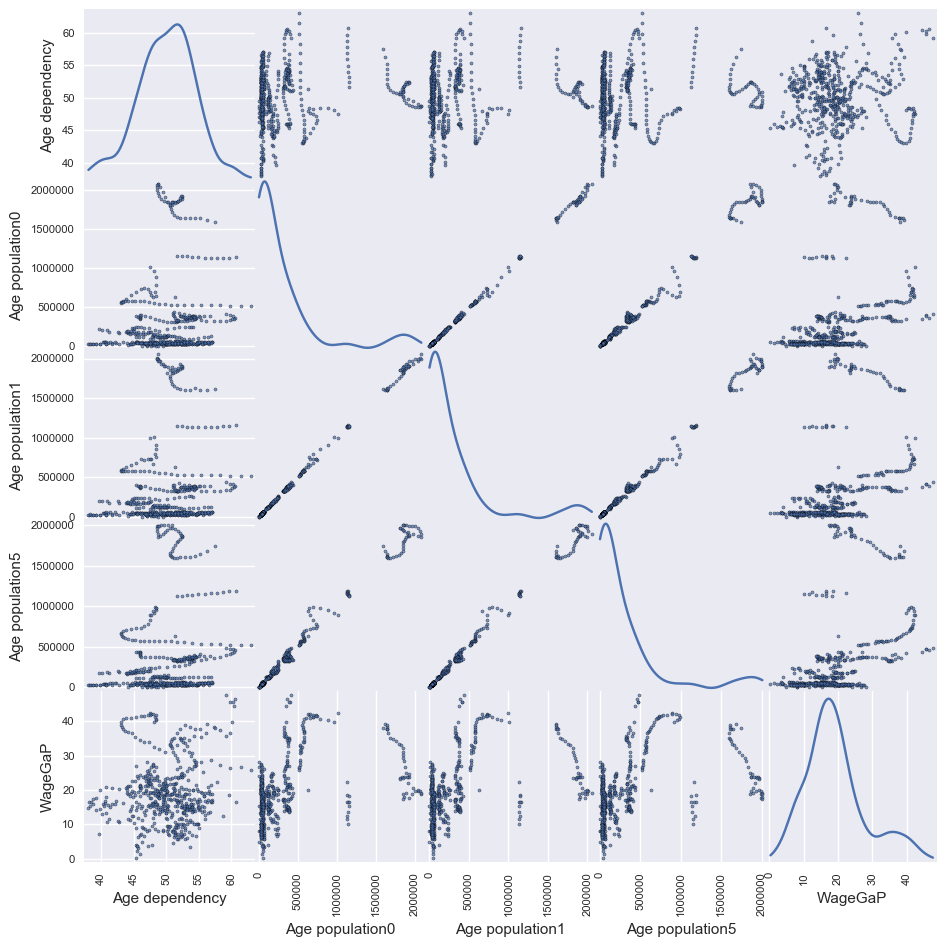

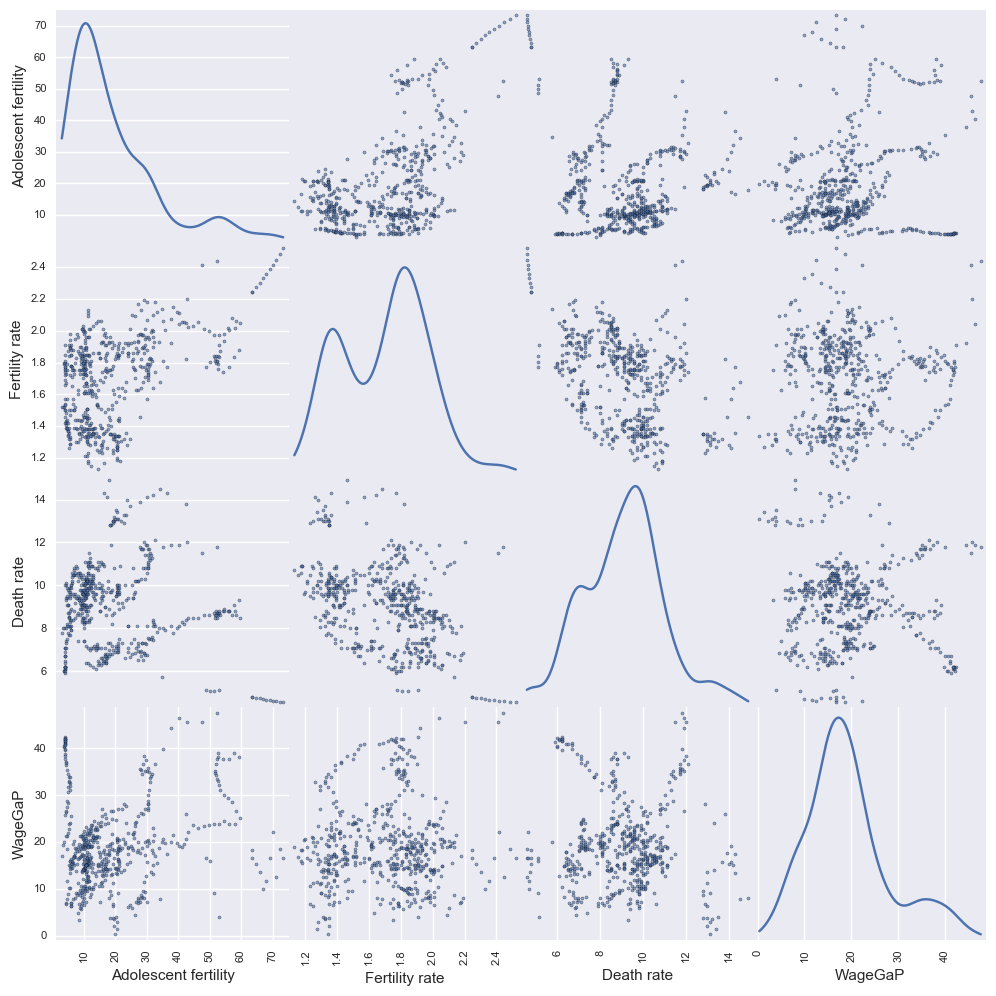

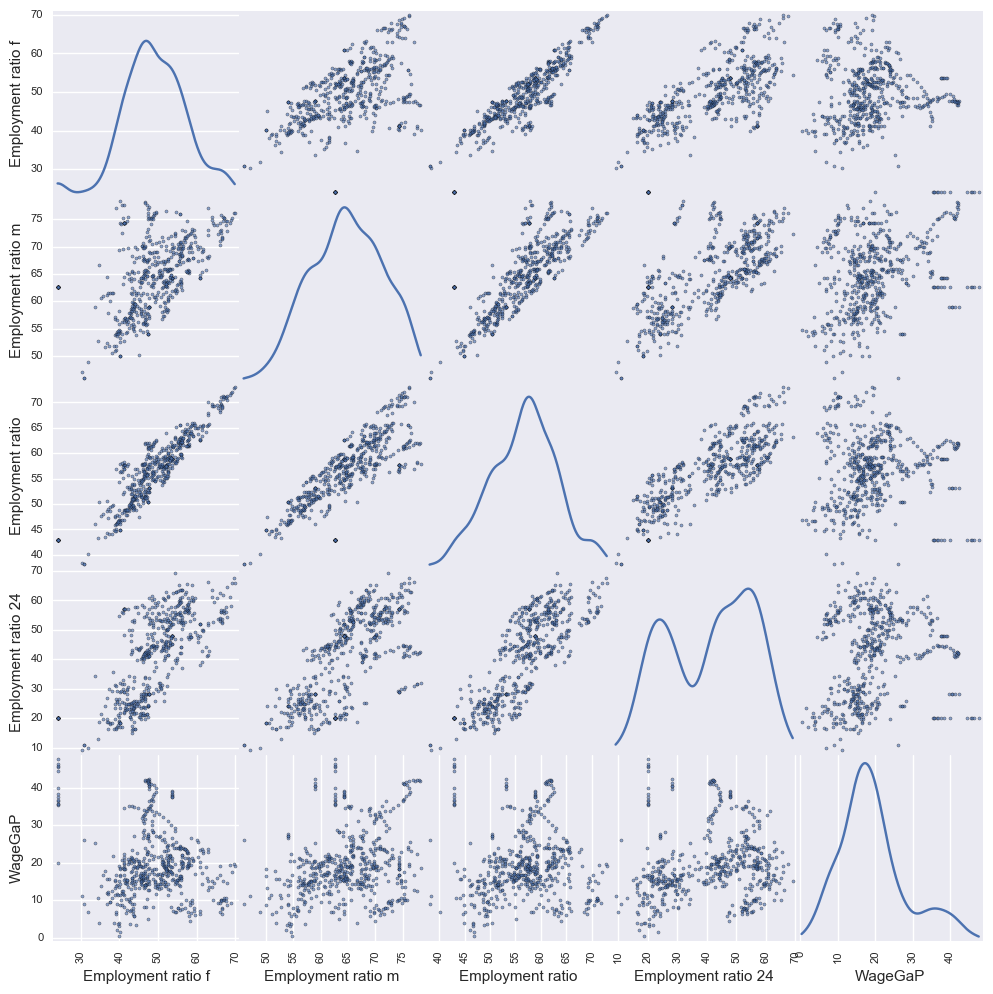

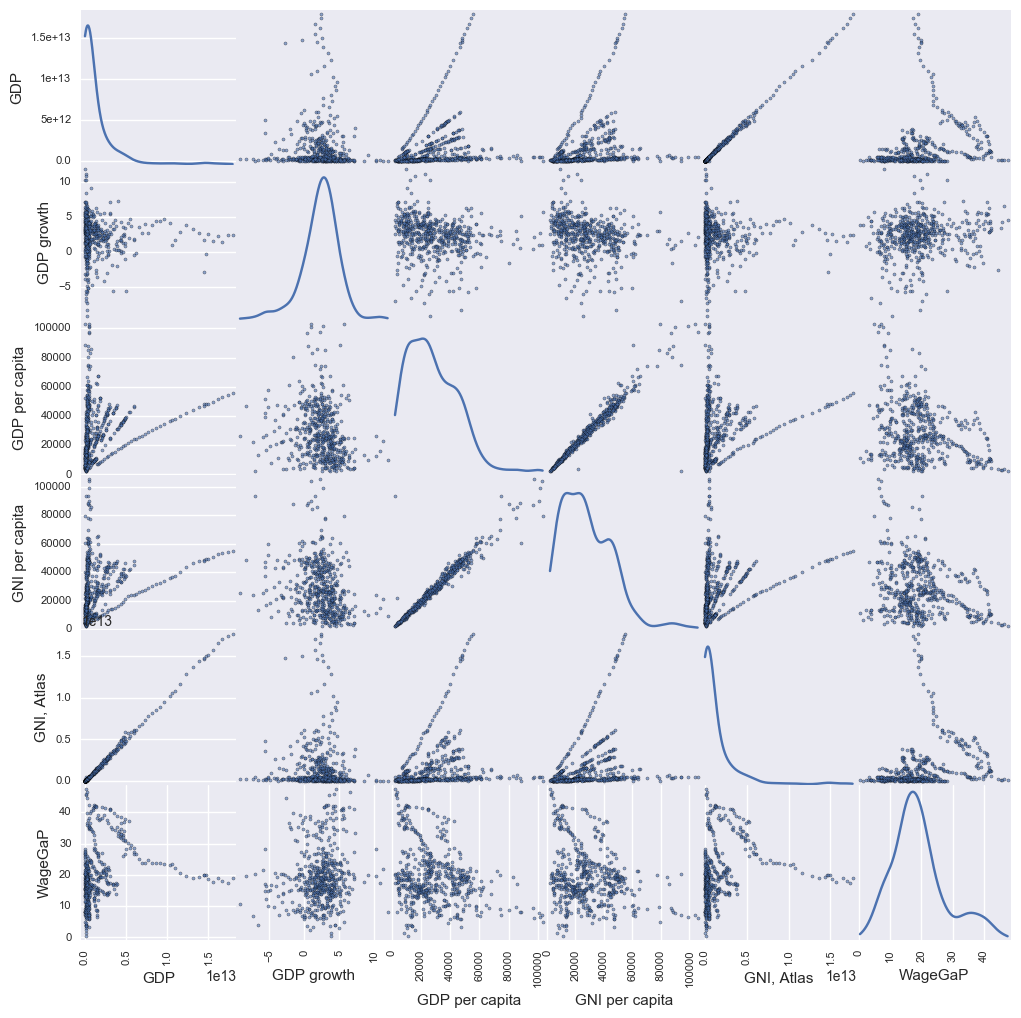

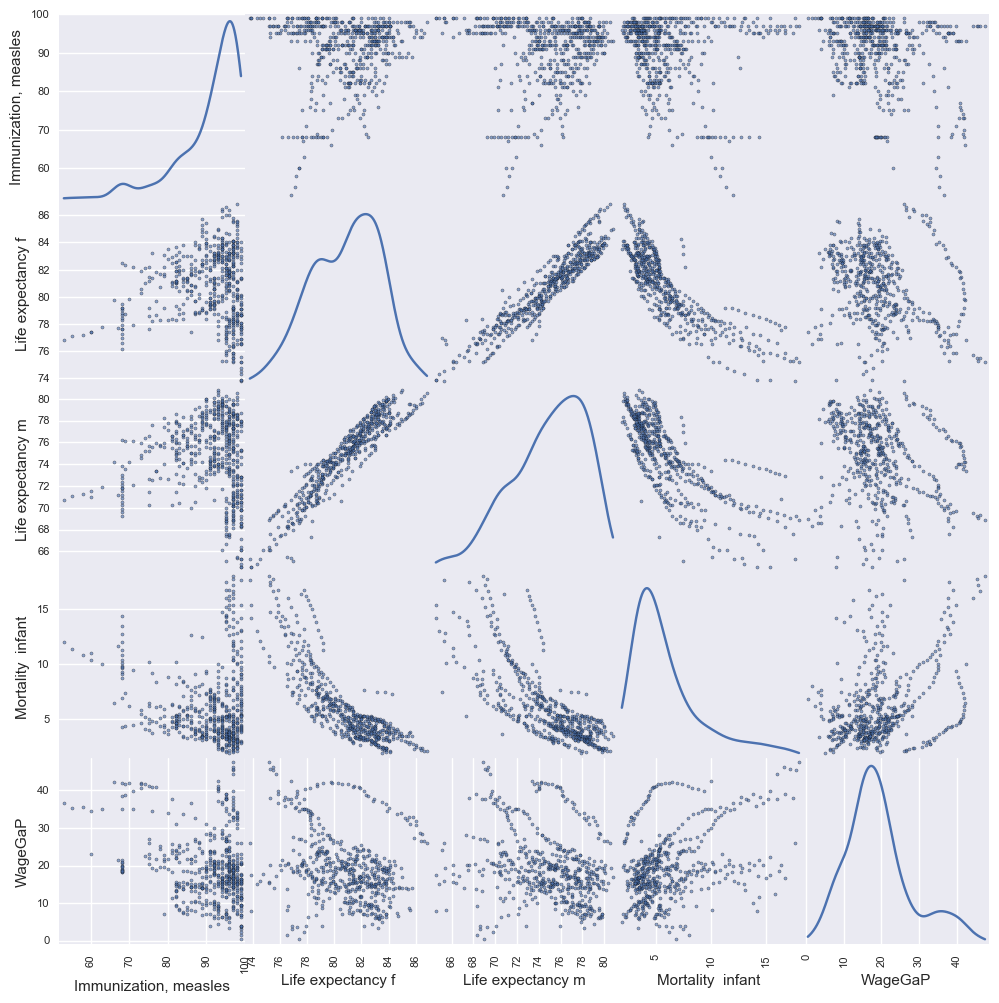

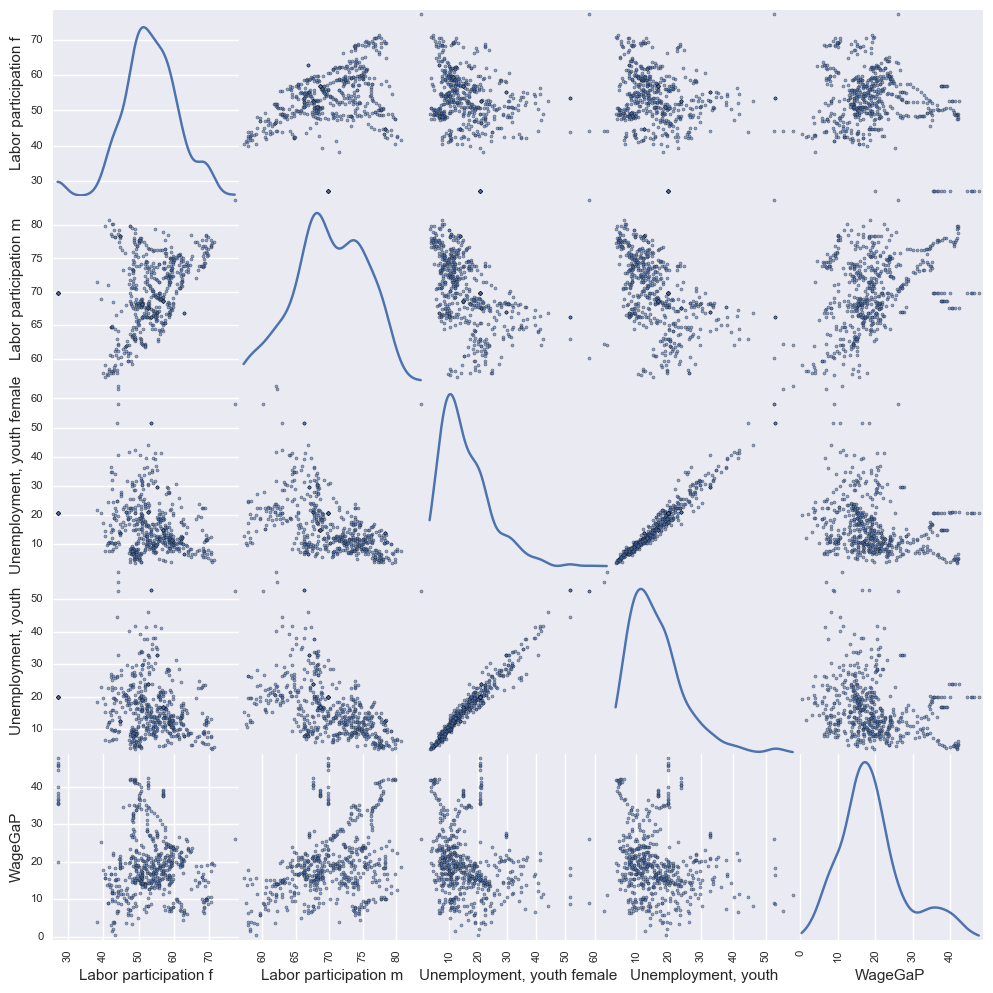

In [142]:
from pandas.tools.plotting import scatter_matrix

#help df for renaming the indicator code with meaningfull names
temp_data_row= pd.read_csv('name_to_code.csv',header = None,skiprows=1)
temp_data_row.columns = ['index','Indicator Name', 'Indicator Code', 'meaning']

correlation_cols = [x for x in remaining_features if 'country' not in x]+['Year']+['WageGaP']
features_df = data_no_na[correlation_cols]
#replace the columns names with codes
#create dict old-new
names_dict ={}
for index,row in temp_data_row.iterrows():
    names_dict[row['Indicator Name']] = row['meaning']
    
features_df= features_df.rename(columns=names_dict)
#output correlations per groups
print ('Selecting correlation groups manually')
group1 = ['Age dependency','Age population0','Age population1','Age population5','WageGaP']

group2 = ['Adolescent fertility','Fertility rate','Death rate','WageGaP']
group3 = ['Employment ratio f','Employment ratio m','Employment ratio','Employment ratio 24','WageGaP']
group4 = ['GDP','GDP growth','GDP per capita','GNI per capita','GNI, Atlas','WageGaP']
group5 = ['Immunization, measles','Life expectancy f','Life expectancy m','Mortality  infant ','WageGaP']
group6 = ['Labor participation f','Labor participation m','Unemployment, youth female','Unemployment, youth','WageGaP']

#print scatter matrix
corr_df1 = features_df[group1]
scatter_matrix(corr_df1, alpha=0.7, figsize=(11, 11), diagonal='kde')

corr_df2 = features_df[group2]
scatter_matrix(corr_df2, alpha=0.6, figsize=(12, 12), diagonal='kde')

corr_df3 = features_df[group3]
scatter_matrix(corr_df3, alpha=0.6, figsize=(12, 12), diagonal='kde')

corr_df4 = features_df[group4]
scatter_matrix(corr_df4, alpha=0.6, figsize=(12, 12), diagonal='kde')

corr_df5 = features_df[group5]
scatter_matrix(corr_df5, alpha=0.6, figsize=(12, 12), diagonal='kde')


corr_df6 = features_df[group6]
scatter_matrix(corr_df6, alpha=0.6, figsize=(12, 12), diagonal='kde')

# 21 Searching for a tuple of feature with a product that has a linear correlation to WageGap 

In [143]:
reaminig_features_without_countries = [x for x in remaining_features if not x.startswith("country-full-name")]
x_remaining_features = x_test[reaminig_features_without_countries]
df_y = pd.DataFrame(data_no_na[['WageGaP']],columns=['WageGaP'])
normalized_data_xy = pd.concat([x_remaining_features,df_y], axis=1, join='inner')

df_pearson = pd.DataFrame(columns=['pearson','feature_tuple'])
pearson_index = 0

df_add_candidates= pd.DataFrame(normalized_data_xy['WageGaP'])

for i in range(len(reaminig_features_without_countries)):
    feat_1 = reaminig_features_without_countries[i]
    
    column_name = "sqr({0})".format(feat_1)
    df_add_candidates[column_name] = np.sqrt(normalized_data_xy[feat_1])
    
    pearson = df_add_candidates[[column_name,'WageGaP']].corr()
    df_pearson.loc[pearson_index]=[abs(pearson.iloc[0]['WageGaP']),column_name]
    pearson_index = pearson_index +1 
    
    column_name = "log({0})".format(feat_1)
    df_add_candidates[column_name] = np.log(normalized_data_xy[feat_1])
    
    pearson = df_add_candidates[[column_name,'WageGaP']].corr()
    df_pearson.loc[pearson_index]=[abs(pearson.iloc[0]['WageGaP']),column_name]
    pearson_index = pearson_index +1 
    
    for j in range(i,len(reaminig_features_without_countries)):        
        feat_2 = reaminig_features_without_countries[j]
        column_name = "{0} * {1}".format(feat_1,feat_2)
        df_add_candidates[column_name] = normalized_data_xy[feat_1] * normalized_data_xy[feat_2]

        pearson = df_add_candidates[[column_name,'WageGaP']].corr()
        df_pearson.loc[pearson_index]=[abs(pearson.iloc[0]['WageGaP']),column_name]
        pearson_index = pearson_index +1 

df_pearson.sort_values(['pearson'], ascending = False).head()

,pearson,feature_tuple
291,0.457725,"Employment to population ratio, ages 15-24, fe..."
402,0.449126,"GNI, Atlas method (current US$) * Population, ..."
332,0.443290,"GDP (current US$) * Population, female (% of t..."
486,0.441099,"Population ages 15-64, female * Population, fe..."
455,0.440484,"Life expectancy at birth, female (years) * Pop..."


we decided to take only tuples of featers which their pearson correlation to the WageGap will be higher than 0.5. all the pearson corr for the product of every two features is lower than 0.5 (lower than 0.46 actually) so we won't add any tuples of features.

# 22 reduce features by correltations

In [144]:
original_feature_count = len(list(features_df))
reduced_features_df = features_df[:]
#1.merge age population cols
age_population_cols =['Age population0','Age population1','Age population5']
age_pop_df = features_df.loc[:,age_population_cols]
age_pop_df['Age population 0-5'] = age_pop_df.mean(axis=1)

#drop the age population columns
reduced_features_df = reduced_features_df.drop('Age population0', axis=1)
reduced_features_df = reduced_features_df.drop('Age population1', axis=1)
reduced_features_df = reduced_features_df.drop('Age population5', axis=1)
reduced_features_df = pd.concat((reduced_features_df, age_pop_df.loc[:,'Age population 0-5']),axis=1)

#2.remove gdp coulmns
reduced_features_df = reduced_features_df.drop('GDP per capita', axis=1)
reduced_features_df = reduced_features_df.drop('GNI per capita', axis=1)

#3. 4.Life expectancy- merge male and female
life_e_cols = ['Life expectancy f','Life expectancy m']
life_e_df = features_df.loc[:,life_e_cols]
life_e_df['Life expectancy f+m'] = life_e_df.mean(axis=1)
reduced_features_df = reduced_features_df.drop('Life expectancy f', axis=1)
reduced_features_df = reduced_features_df.drop('Life expectancy m', axis=1)
reduced_features_df = pd.concat((reduced_features_df, life_e_df['Life expectancy f+m']),axis=1)
#remove - Unemployment, youth female, low t-test and linear correlation to total value
reduced_features_df = reduced_features_df.drop('Unemployment, youth female', axis=1)

#reorder columns
cols = list(reduced_features_df)
final_df = pd.concat((reduced_features_df[cols[:-3]],reduced_features_df[cols[-2]],reduced_features_df[cols[-1]],reduced_features_df[cols[-3]]),axis=1)

print('Reduced features amount from {0} to {1} without countries'.format(original_feature_count,len(list(final_df))))

Reduced features amount from 32 to 26 without countries


# 23 remove low  t-test features

In [145]:
final_df.drop('GDP', axis=1, inplace=True)
countries_cols = [x for x in remaining_features if 'country' in x]
contry_df = data_no_na[countries_cols]
contry_df = contry_df.drop('country-full-name_Spain', axis=1)
remaining_countries_count=remaining_countries_count-1
full_df = pd.concat((contry_df,final_df),axis=1)

remaining_features_new_with_WageGaP = full_df.columns.tolist()
remaining_features_new = [x for x in full_df.columns.tolist() if not x=='WageGaP']

full_df.head()

,country-full-name_Australia,country-full-name_Austria,country-full-name_Belgium,country-full-name_Canada,country-full-name_Chile,country-full-name_Czech Republic,country-full-name_Denmark,country-full-name_Estonia,country-full-name_Finland,country-full-name_France,...,"Population ages 15-64, female",Population f,School enrollment,School enrollment f,"Unemployment, youth",Wage salaried workers f,Year,Age population 0-5,Life expectancy f+m,WageGaP
0,1,0,0,0,0,0,0,0,0,0,...,4358162.0,49.851432,0.99476,107.268402,12.5,87.099998,1975.0,125622.000000,72.71,21.582733
1,1,0,0,0,0,0,0,0,0,0,...,4415430.0,49.897011,0.99183,107.989410,12.5,87.099998,1976.0,124702.000000,73.10,20.754717
2,1,0,0,0,0,0,0,0,0,0,...,4489241.0,49.948314,0.99184,109.968758,12.5,87.099998,1977.0,118779.333333,73.43,18.390804
3,1,0,0,0,0,0,0,0,0,0,...,4570572.0,49.999210,0.99105,110.979317,12.5,87.099998,1978.0,114415.666667,73.76,19.791666
4,1,0,0,0,0,0,0,0,0,0,...,4646522.0,50.041641,0.99036,110.500870,12.5,87.099998,1979.0,110822.666667,74.09,20.000000


# 25 creating new x and y with the reduced features

In [147]:
#split to X and y
x_reduced = full_df[list(full_df)[:-1]]

y_reduced_train = full_df[full_df['Year'] < traintest_threshold ]
y_reduced_train = y_reduced_train['WageGaP']

y_reduced_test = full_df[full_df['Year'] >= traintest_threshold ]
y_reduced_test = y_reduced_test['WageGaP']

#Normelize all values in x
l = list(full_df)
x_reduced_normelize = pd.DataFrame(sp.MinMaxScaler().fit_transform(full_df),columns = l)
x_reduced_normelize.drop('WageGaP', axis=1, inplace=True)

#split to train and test data
min_year = min(full_df['Year']); max_year=max(full_df['Year']);
normalized_threshold = ((traintest_threshold - min_year)/(max_year - min_year))
x_reduced_train = x_reduced_normelize[x_reduced_normelize['Year'] < normalized_threshold]
x_reduced_test = x_reduced_normelize[x_reduced_normelize['Year'] >= normalized_threshold]

# 24 Features Engineering 2

Searching for a tuple of feature with a product that has a linear correlation to WageGap - on new reduced df

In [148]:
reduced_reaminig_features_without_countries = [x for x in remaining_features_new if (not x.startswith("country-full-name") and not x.startswith('Year'))]

x_remaining_features = x_reduced[reduced_reaminig_features_without_countries]

df_y = pd.DataFrame(full_df[['WageGaP']],columns=['WageGaP'])

normalized_data_xy_reduced = pd.concat([x_remaining_features,df_y], axis=1, join='inner')

df_pearson = pd.DataFrame(columns=['pearson','feature_tuple'])

pearson_index = 0

df_add_candidates= pd.DataFrame(normalized_data_xy_reduced['WageGaP'])

for i in range(len(reduced_reaminig_features_without_countries)):
    feat_1 = reduced_reaminig_features_without_countries[i]
    
    column_name = "sqr({0})".format(feat_1)
    df_add_candidates[column_name] = np.sqrt(normalized_data_xy_reduced[feat_1])
    
    pearson = df_add_candidates[[column_name,'WageGaP']].corr()
    df_pearson.loc[pearson_index]=[abs(pearson.iloc[0]['WageGaP']),column_name]
    pearson_index = pearson_index +1 
    
    column_name = "log({0})".format(feat_1)
    df_add_candidates[column_name] = np.log(normalized_data_xy_reduced[feat_1])
    
    pearson = df_add_candidates[[column_name,'WageGaP']].corr()
    df_pearson.loc[pearson_index]=[abs(pearson.iloc[0]['WageGaP']),column_name]
    pearson_index = pearson_index +1 
    
    for j in range(i,len(reduced_reaminig_features_without_countries)):        
        feat_2 = reduced_reaminig_features_without_countries[j]
        column_name = "{0} * {1}".format(feat_1,feat_2)
        df_add_candidates[column_name] = normalized_data_xy_reduced[feat_1] * normalized_data_xy_reduced[feat_2]

        pearson = df_add_candidates[[column_name,'WageGaP']].corr()
        df_pearson.loc[pearson_index]=[abs(pearson.iloc[0]['WageGaP']),column_name]
        pearson_index = pearson_index +1 

df_sorted_pearson = df_pearson.sort_values(['pearson'], ascending = False)
df_sorted_pearson.head()

,pearson,feature_tuple
316,0.537829,log(Age population 0-5)
271,0.532940,"log(Population ages 15-64, female)"
270,0.529919,"sqr(Population ages 15-64, female)"
315,0.517632,sqr(Age population 0-5)
127,0.469880,"Employment ratio m * Population ages 15-64, fe..."


We decided to take only tuples of featers which their pearson correlation to the WageGap will be higher than 0.5.
then we will add the top 4 to the features

In [149]:
added_feat = remaining_features_new.copy()

for i in range(4):
    feature_name = df_sorted_pearson.iloc[i]['feature_tuple']
    added_feat.append(feature_name)
    full_df[feature_name] = df_add_candidates[feature_name]

remaining_features_new = added_feat.copy()

AttributeError: 'list' object has no attribute 'copy'

# 25 creating new x and y with the new features

In [169]:
#split to X and y
x_reduced = full_df[list(full_df)[:-1]]

y_reduced_train = full_df[full_df['Year'] < traintest_threshold ]
y_reduced_train = y_reduced_train['WageGaP']

y_reduced_test = full_df[full_df['Year'] >= traintest_threshold ]
y_reduced_test = y_reduced_test['WageGaP']

#Normelize all values in x
l = list(full_df)
x_reduced_normelize = pd.DataFrame(sp.MinMaxScaler().fit_transform(full_df),columns = l)
x_reduced_normelize.drop('WageGaP', axis=1, inplace=True)

#split to train and test data
min_year = min(full_df['Year']); max_year=max(full_df['Year']);
normalized_threshold = ((traintest_threshold - min_year)/(max_year - min_year))
x_reduced_train = x_reduced_normelize[x_reduced_normelize['Year'] < normalized_threshold]
x_reduced_test = x_reduced_normelize[x_reduced_normelize['Year'] >= normalized_threshold]

# 26 New Data Modeling - after changes

## 26.1 ML - linear regression using statsmodels

In [170]:
x_reduced_train_stats = x_reduced_train

stats_model = sm.OLS(y_reduced_train,x_reduced_train_stats)
stats_model_results = stats_model.fit()
#printing model output including t-test results
print(stats_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                WageGaP   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1284.
Date:                Thu, 16 Feb 2017   Prob (F-statistic):               0.00
Time:                        19:00:28   Log-Likelihood:                -820.45
No. Observations:                 414   AIC:                             1737.
Df Residuals:                     366   BIC:                             1930.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------


## 26.2 mse calculation

In [171]:
x_reduced_test_stats = x_reduced_test
y_hat_reduced_test_stats = stats_model_results.predict(x_reduced_test_stats)
err = metrics.mean_squared_error(y_reduced_test,y_hat_reduced_test_stats)
#run stat models and predict
print ('statsmodel test mse is : %.2f' %err)

statsmodel test mse is : 15.48


# 27 - Visualization for new model

## 27.1 test_Prediction vs test_Data (statsmodel)

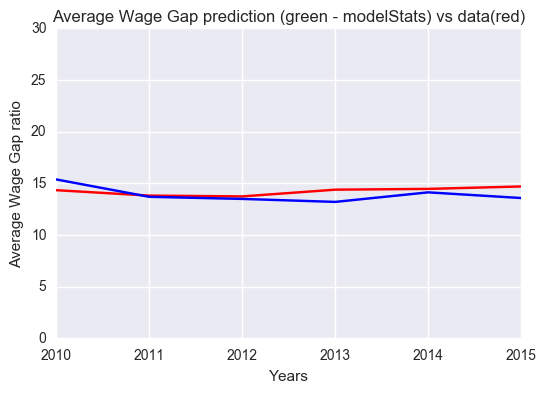

In [172]:
%matplotlib inline

test = full_df[full_df['Year'] >= traintest_threshold]

plot_data = test[['Year','WageGaP']]
plot_data = plot_data.groupby('Year').mean()

cols = test.columns.tolist()
test_2 = test.reset_index(drop=True)
test_2.columns = cols

df_y_hat_stats = pd.DataFrame(data=y_hat_reduced_test_stats,columns=['WageGaPPredict'])

df_prediction_stats = pd.concat([test_2,df_y_hat_stats], axis=1, join='inner')
plot_Prediction_stats = df_prediction_stats[['Year','WageGaPPredict']]
plot_Prediction_stats = plot_Prediction_stats.groupby('Year').mean()

lines = plt.plot(plot_data.index,plot_data.WageGaP,color='r')
lines = plt.plot(plot_Prediction_stats.index,plot_Prediction_stats.WageGaPPredict,color='b')

plt.ylabel('Average Wage Gap ratio')
plt.xlabel('Years')
plt.title('Average Wage Gap prediction (green - modelStats) vs data(red)')
plt.ylim(0,30)
plt.xlim(traintest_threshold,2015)
plt.ticklabel_format(useOffset=False)
plt.show()

## 27.2 Test prediction vs data Average error precentage

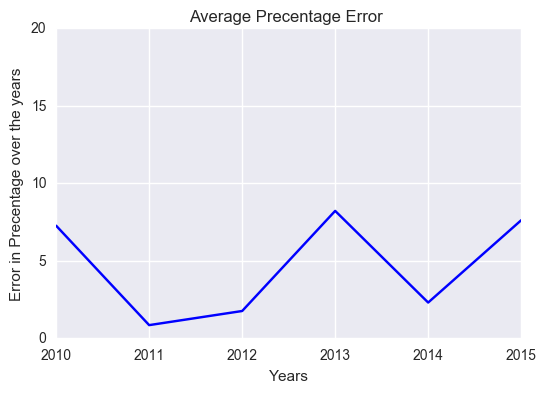

average error using modelstats in precentage: 4.67
max error using modelstats in precentage: 8.22


In [182]:
# preparing data for stats
test = full_df[full_df['Year'] >= traintest_threshold]

cols = test.columns.tolist()
test_2 = test.reset_index(drop=True)
test_2.columns = cols

df_y_hat_stats = pd.DataFrame(data=y_hat_reduced_test_stats,columns=['WageGaPPredict'])

df_prediction_and_data_stats = pd.concat([test_2,df_y_hat_stats], axis=1, join='inner')

df_data_stats = df_prediction_and_data_stats[['Year','WageGaP']]
df_prediction_stats = df_prediction_stats[['Year','WageGaPPredict']]

df_data_stats_mean = df_data_stats.groupby('Year').mean()
df_prediction_stats_mean = df_prediction_stats.groupby('Year').mean()
df_prediction_and_data_stats_mean = pd.concat([df_data_stats_mean,df_prediction_stats_mean], axis=1, join='inner')

precentage_error_stats = ((abs(df_prediction_and_data_stats_mean['WageGaPPredict']-df_prediction_and_data_stats_mean['WageGaP'])/df_prediction_and_data_stats_mean['WageGaP'])*100)
df_precentage_error_stats = pd.DataFrame(data=precentage_error_stats,columns=['PrecentageErr'])

plot_precentageErr_stats = pd.concat([df_prediction_and_data_stats_mean,df_precentage_error_stats], axis=1, join='inner') 

lines = plt.plot(plot_precentageErr_stats.index,plot_precentageErr_stats.PrecentageErr,color='b')

plt.ylabel('Error in Precentage over the years')
plt.xlabel('Years')
plt.title('Average Precentage Error ')
plt.ylim(0,20)
plt.ticklabel_format(useOffset=False)
plt.show()

err_mean_stats = np.mean(plot_precentageErr_stats.PrecentageErr)
err_max_stats = np.max(plot_precentageErr_stats.PrecentageErr)

print('average error using modelstats in precentage: %.2f' %err_mean_stats)
print('max error using modelstats in precentage: %.2f' %err_max_stats)

## 27.3 Run statsmodels Model on train and test

In [174]:
y_hat_reduced_stats = stats_model_results.predict(x_reduced_normelize)

## 27.4 Visualize Prediction Vs Data Train and Test (statsmodels)

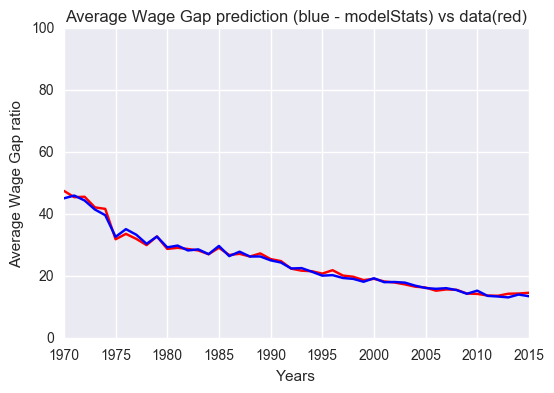

In [175]:
%matplotlib inline

plot_data = full_df[['Year','WageGaP']]
plot_data = plot_data.groupby('Year').mean()

df_y_hat_stats = pd.DataFrame(data=y_hat_reduced_stats,columns=['WageGaPPredict'])

df_prediction_stats = pd.concat([full_df,df_y_hat_stats], axis=1, join='inner')
plot_Prediction_stats = df_prediction_stats[['Year','WageGaPPredict']]
plot_Prediction_stats = plot_Prediction_stats.groupby('Year').mean()

lines = plt.plot(plot_data.index,plot_data.WageGaP,color='r')
lines = plt.plot(plot_Prediction_stats.index,plot_Prediction_stats.WageGaPPredict,color='b')

plt.ylabel('Average Wage Gap ratio')
plt.xlabel('Years')
plt.title('Average Wage Gap prediction (blue - modelStats) vs data(red)')
plt.ylim(0,100)
plt.show()

## 27.5 Avg error precetage

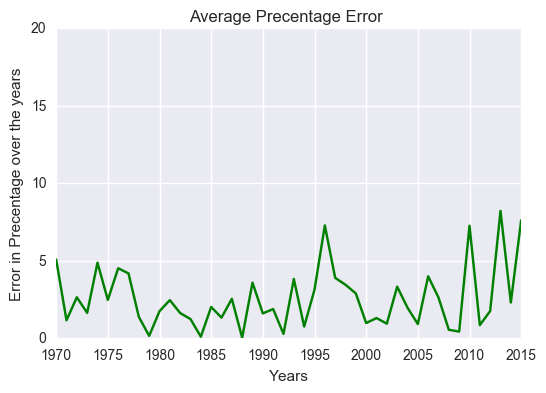

average error in precentage: 2.59
max error in precentage: 8.22


In [157]:
df_y_hat_stats = pd.DataFrame(data=y_hat_reduced_stats,columns=['WageGaPPredict'])

df_prediction_and_data_stats = pd.concat([full_df,df_y_hat_stats], axis=1, join='inner')


df_data_stats = df_prediction_and_data_stats[['Year','WageGaP']]
df_prediction_stats = df_prediction_and_data_stats[['Year','WageGaPPredict']]

df_data_stats_mean = df_data_stats.groupby('Year').mean()
df_prediction_stats_mean = df_prediction_stats.groupby('Year').mean()

df_prediction_and_data_stats_mean = pd.concat([df_data_stats_mean,df_prediction_stats_mean], axis=1, join='inner')

precentage_error_stats = ((abs(df_prediction_and_data_stats_mean['WageGaPPredict']-df_prediction_and_data_stats_mean['WageGaP'])/df_prediction_and_data_stats_mean['WageGaP'])*100)
df_precentage_error_stats = pd.DataFrame(data=precentage_error_stats,columns=['PrecentageErr'])

plot_precentageErr_stats = pd.concat([df_prediction_and_data_stats_mean,df_precentage_error_stats], axis=1, join='inner') 


lines = plt.plot(plot_precentageErr_stats.index,plot_precentageErr_stats.PrecentageErr,color='g')

plt.ylabel('Error in Precentage over the years')
plt.xlabel('Years')
plt.title('Average Precentage Error ')
plt.ylim(0,20)
plt.ticklabel_format(useOffset=False)
plt.show()

mean_err = np.mean(plot_precentageErr_stats.PrecentageErr)
max_err = np.max(plot_precentageErr_stats.PrecentageErr)

print('average error in precentage: %.2f' %mean_err)
print('max error in precentage: %.2f' %max_err)

# 28 Future Prediction

# 28.1 first method - using interpolate (spline order 1)

In [158]:
# from outside
y = full_df['WageGaP'].copy()

# all local variables
df_y_hat = pd.DataFrame(data=y,columns=['WageGaP'])
df_y_hat.loc[len(df_y_hat)] = [np.nan]

#it just copies the last value 
df_y_hat = df_y_hat.interpolate(limit_direction='forward', method='spline', order=1,limit=None)

print('WageGap in 2016 prediction by interpolating the real data:' )
print(df_y_hat.iloc[len(pearson)-1]['WageGaP'])

WageGap in 2016 prediction by interpolating the real data:
20.754717


## 28.2 second method - using interpolate to predict feature  and use model to predict wage gap (spline order 1)

In [159]:
# from outside
df_with2016 = full_df.copy()

# all local variable
features_list = df_with2016.columns.tolist()
countries = [x for x in features_list if x.startswith("country-full-name")]
feats_no_countries = [x for x in features_list if not x.startswith("country-full-name")]

#prepare extraoplate
# Function to curve fit to the data
def func(x, a, b):
    return a * x + b

# Initial parameter guess, just to kick off the optimization
guess = (0.5, 0.5)

for i in range(len(countries)):
    country = countries[i]
    df_country = full_df[full_df[country] == 1].copy()
        
    df_country = df_country.sort_values(['Year'])
    cols = df_country.columns.tolist()
    df_country_with2016 = df_country.reset_index(drop=True)
    df_country_with2016.columns = cols
    
    df_country_with2016 = df_country_with2016.sort_values(['Year'])

    last_country_year = df_country_with2016.loc[len(df_country_with2016)-1,'Year']
    if(last_country_year < 2016):
        num_of_years_to_fill = 2016 - last_country_year
        for j in range(num_of_years_to_fill.astype(np.integer)):
            current_row_in_country_df = len(df_country_with2016)
            df_country_with2016.loc[current_row_in_country_df] = [np.nan]*len(features_list)
            df_country_with2016.loc[current_row_in_country_df,country] = 1.0
            df_country_with2016.loc[current_row_in_country_df,'Year'] = last_country_year + j + 1
    
            # fill other countries with  0
            for other_country in countries:
                if(not other_country==country):
                    df_country_with2016.loc[current_row_in_country_df,other_country] = 0.0
                    
            df_country_with2016 = df_country_with2016.interpolate(limit_direction='forward', method='spline', order=1, limit=None)
            row_to_add = df_country_with2016.loc[current_row_in_country_df]
            
            # add line to main DF
            current_row = len(df_with2016)
            df_with2016.loc[current_row] = row_to_add

In [160]:
# from outside
df_future_prediction = df_with2016.copy()

# all local variables from this point on

#split to X and y
x_future_prediction = df_future_prediction[list(df_future_prediction)[:-1]]

#Normelize all values in x
l = list(df_future_prediction)
x_future_prediction_normelize = pd.DataFrame(sp.MinMaxScaler().fit_transform(df_future_prediction),columns = l)
x_future_prediction_normelize.drop('WageGaP', axis=1, inplace=True)

#split to train and test data
min_year = min(x_future_prediction_normelize['Year']); max_year=max(x_future_prediction_normelize['Year']);
normalized_2017 = ((2017 - min_year)/(max_year - min_year))

y_hat_future_prediction = stats_model_results.predict(x_future_prediction_normelize)
df_y_hat_future_prediction = pd.DataFrame(data=y_hat_future_prediction,columns=['WageGaPPredict'])

df_future_prediction_data_and_predict = pd.concat([df_future_prediction,df_y_hat_future_prediction], axis=1, join='inner')

features_list = df_future_prediction.columns.tolist()
countries = [x for x in features_list if x.startswith("country-full-name")]
feats_no_countries = [x for x in features_list if not x.startswith("country-full-name")]

df_future_prediction_data_and_predict_mean = df_future_prediction_data_and_predict[['Year','WageGaPPredict']]
    
df_future_prediction_data_and_predict_mean = df_future_prediction_data_and_predict_mean.groupby('Year').mean()

print("WageGap Prediction For 2016 using feature prediction is:")
print(df_future_prediction_data_and_predict_mean[df_future_prediction_data_and_predict_mean.index == 2016].iloc[0,0])

WageGap Prediction For 2016 using feature prediction is:
9.78458524092


## 28.3 first method - using interpolate (spline order 2)

In [161]:
# from outside
y = full_df['WageGaP'].copy()

# all local variables
df_y_hat = pd.DataFrame(data=y,columns=['WageGaP'])
df_y_hat.loc[len(df_y_hat)] = [np.nan]

#it just copies the last value 
df_y_hat = df_y_hat.interpolate(limit_direction='forward', method='spline', order=2,limit=None)

print('WageGap in 2016 prediction by interpolating the real data:' )
print(df_y_hat.iloc[len(pearson)-1]['WageGaP'])

WageGap in 2016 prediction by interpolating the real data:
20.754717


## 28.4 second method - using interpolate to predict feature  and use model to predict wage gap (spline order 2)

In [162]:
# from outside
df_with2016 = full_df.copy()

# all local variable
features_list = df_with2016.columns.tolist()
countries = [x for x in features_list if x.startswith("country-full-name")]
feats_no_countries = [x for x in features_list if not x.startswith("country-full-name")]

#prepare extraoplate
# Function to curve fit to the data
def func(x, a, b):
    return a * x + b

# Initial parameter guess, just to kick off the optimization
guess = (0.5, 0.5)

for i in range(len(countries)):
    country = countries[i]
    df_country = full_df[full_df[country] == 1].copy()
    
    df_country = df_country.sort_values(['Year'])
    cols = df_country.columns.tolist()
    df_country_with2016 = df_country.reset_index(drop=True)
    df_country_with2016.columns = cols
    
    df_country_with2016 = df_country_with2016.sort_values(['Year'])
    
    last_country_year = df_country_with2016.loc[len(df_country_with2016)-1,'Year']
    if(last_country_year < 2016):
        num_of_years_to_fill = 2016 - last_country_year
        for j in range(num_of_years_to_fill.astype(np.integer)):
            current_row_in_country_df = len(df_country_with2016)
            df_country_with2016.loc[current_row_in_country_df] = [np.nan]*len(features_list)
            df_country_with2016.loc[current_row_in_country_df,country] = 1.0
            df_country_with2016.loc[current_row_in_country_df,'Year'] = last_country_year + j + 1
    
            # fill other countries with  0
            for other_country in countries:
                if(not other_country==country):
                    df_country_with2016.loc[current_row_in_country_df,other_country] = 0.0
                    
            df_country_with2016 = df_country_with2016.interpolate(limit_direction='forward', method='spline', order=2, limit=None)
            row_to_add = df_country_with2016.loc[current_row_in_country_df]
            
            # add line to main DF
            current_row = len(df_with2016)
            df_with2016.loc[current_row] = row_to_add

In [163]:
# from outside
df_future_prediction = df_with2016.copy()

# all local variables from this point on

#split to X and y
x_future_prediction = df_future_prediction[list(df_future_prediction)[:-1]]

#Normelize all values in x
l = list(df_future_prediction)
x_future_prediction_normelize = pd.DataFrame(sp.MinMaxScaler().fit_transform(df_future_prediction),columns = l)
x_future_prediction_normelize.drop('WageGaP', axis=1, inplace=True)

#split to train and test data
min_year = min(x_future_prediction_normelize['Year']); max_year=max(x_future_prediction_normelize['Year']);
normalized_2017 = ((2017 - min_year)/(max_year - min_year))

y_hat_future_prediction = stats_model_results.predict(x_future_prediction_normelize)
df_y_hat_future_prediction = pd.DataFrame(data=y_hat_future_prediction,columns=['WageGaPPredict'])

df_future_prediction_data_and_predict = pd.concat([df_future_prediction,df_y_hat_future_prediction], axis=1, join='inner')

features_list = df_future_prediction.columns.tolist()
countries = [x for x in features_list if x.startswith("country-full-name")]
feats_no_countries = [x for x in features_list if not x.startswith("country-full-name")]

df_future_prediction_data_and_predict_mean = df_future_prediction_data_and_predict[['Year','WageGaPPredict']]
    
df_future_prediction_data_and_predict_mean = df_future_prediction_data_and_predict_mean.groupby('Year').mean()

print("WageGap Prediction For 2016 using feature prediction is:")
print(df_future_prediction_data_and_predict_mean[df_future_prediction_data_and_predict_mean.index == 2016].iloc[0,0])

WageGap Prediction For 2016 using feature prediction is:
20.718314772


# 29 plot graph - infant mortality, adolcent fertiliy average(on all countries) vs years

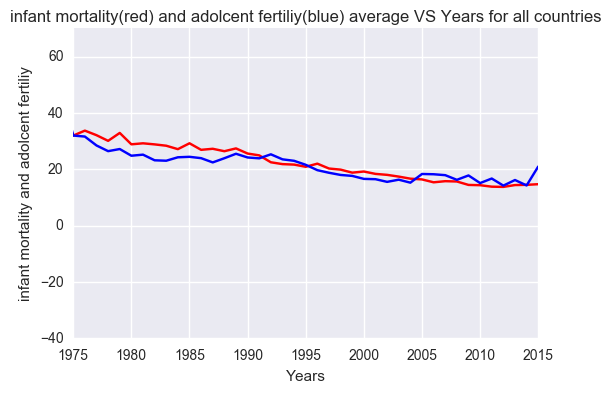

In [164]:
%matplotlib inline
#creating yeaars vector for x axis:
x = data_no_na[list(data_no_na)[:-1]]
#create x vector
plot_data = data_no_na
years = set(plot_data['Year'])
years=list(years)


#first graph calculation- infant mortality
graph1_column = 'Mortality rate, infant (per 1,000 live births)'
aggregated_mortality = plot_data.groupby('Year').mean()[graph1_column]
aggregated_mortality_avg = aggregated.to_frame(name='infant_mortality_avg')
np_array_mortality_average = aggregated_mortality_avg['infant_mortality_avg'].values

#second graph calculation-adolcent fertiliy
graph2_column = 'Adolescent fertility rate (births per 1,000 women ages 15-19)'
aggregated_fertility = plot_data.groupby('Year').mean()[graph2_column]
aggregated_fertility_avg = aggregated_fertility.to_frame(name='fertility_rate_avg')
np_array_fertility_average = aggregated_fertility_avg['fertility_rate_avg'].values

#plot graphs
plt.show()
plot_tuple = ()

#first graph:
plot_tuple = plot_tuple+(years,np_array_mortality_average.tolist(),'r')
#second graph
plot_tuple = plot_tuple+(years,np_array_fertility_average.tolist(),'b')

for i in range(0,len(plot_tuple),3):
    plt.plot(plot_tuple[i],plot_tuple[i+1],plot_tuple[i+2])
    
plt.ylabel('infant mortality and adolcent fertiliy')
plt.xlabel('Years')
plt.title('infant mortality(red) and adolcent fertiliy(blue) average VS Years for all countries')
plt.xlim(1975,2015)
plt.ylim(-40,70)
plt.show()

# 30 Checking feature correction

## 30.1 linear regression without countries

In [183]:
x_reduced_train_stats = x_reduced_train
#remove countries from x_reduced_train_stats
x_reduced_train_stats=x_reduced_train_stats.iloc[:,remaining_countries_count:]


stats_model = sm.OLS(y_reduced_train,x_reduced_train_stats)
stats_model_results = stats_model.fit()
#printing model output including t-test results
print(stats_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                WageGaP   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     539.0
Date:                Thu, 16 Feb 2017   Prob (F-statistic):          3.42e-282
Time:                        19:37:18   Log-Likelihood:                -1151.8
No. Observations:                 414   AIC:                             2352.
Df Residuals:                     390   BIC:                             2448.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------


# 30.1.1 calculating average error

In [184]:
y_hat_reduced_test_stats = stats_model_results.predict(x_reduced_test_stats)
err = metrics.mean_squared_error(y_reduced_test,y_hat_reduced_test_stats)
#run stat models and predict
print ('statsmodel test without countries mse is : %.2f' %err)

statsmodel test without countries mse is : 25.34


printing the Average Error

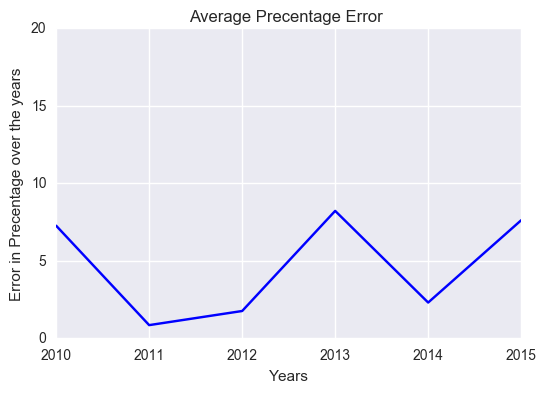

average error using modelstats in precentage without countries: 4.67
max error using modelstats in precentage without countries: 8.22


In [185]:
# preparing data for stats
test = full_df[full_df['Year'] >= traintest_threshold]

cols = test.columns.tolist()
test_2 = test.reset_index(drop=True)
test_2.columns = cols

df_y_hat_stats = pd.DataFrame(data=y_hat_reduced_test_stats,columns=['WageGaPPredict'])

df_prediction_and_data_stats = pd.concat([test_2,df_y_hat_stats], axis=1, join='inner')

df_data_stats = df_prediction_and_data_stats[['Year','WageGaP']]
df_prediction_stats = df_prediction_stats[['Year','WageGaPPredict']]

df_data_stats_mean = df_data_stats.groupby('Year').mean()
df_prediction_stats_mean = df_prediction_stats.groupby('Year').mean()
df_prediction_and_data_stats_mean = pd.concat([df_data_stats_mean,df_prediction_stats_mean], axis=1, join='inner')

precentage_error_stats = ((abs(df_prediction_and_data_stats_mean['WageGaPPredict']-df_prediction_and_data_stats_mean['WageGaP'])/df_prediction_and_data_stats_mean['WageGaP'])*100)
df_precentage_error_stats = pd.DataFrame(data=precentage_error_stats,columns=['PrecentageErr'])

plot_precentageErr_stats = pd.concat([df_prediction_and_data_stats_mean,df_precentage_error_stats], axis=1, join='inner') 

lines = plt.plot(plot_precentageErr_stats.index,plot_precentageErr_stats.PrecentageErr,color='b')

plt.ylabel('Error in Precentage over the years')
plt.xlabel('Years')
plt.title('Average Precentage Error ')
plt.ylim(0,20)
plt.ticklabel_format(useOffset=False)
plt.show()

err_mean_stats = np.mean(plot_precentageErr_stats.PrecentageErr)
err_max_stats = np.max(plot_precentageErr_stats.PrecentageErr)

print('average error using modelstats in precentage without countries: %.2f' %err_mean_stats)
print('max error using modelstats in precentage without countries: %.2f' %err_max_stats)

## 30.2 linear regression only on countries

In [186]:
x_reduced_train_stats = x_reduced_train
#selecting only the countries
x_reduced_train_stats_countries = x_reduced_train_stats.iloc[:,:remaining_countries_count]


stats_model = sm.OLS(y_reduced_train,x_reduced_train_stats_countries)
stats_model_results = stats_model.fit()
#printing model output including t-test results
print(stats_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                WageGaP   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     219.8
Date:                Thu, 16 Feb 2017   Prob (F-statistic):          6.02e-210
Time:                        19:37:31   Log-Likelihood:                -1328.9
No. Observations:                 414   AIC:                             2706.
Df Residuals:                     390   BIC:                             2802.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------
countr

### 30.2.1 calc and print the average error

In [187]:
y_hat_reduced_test_stats = stats_model_results.predict(x_reduced_train_stats_countries)
err = metrics.mean_squared_error(y_reduced_test,y_hat_reduced_test_stats)
#run stat models and predict
print ('statsmodel test without countries mse is : %.2f' %err)

ValueError: Found arrays with inconsistent numbers of samples: [126 414]